# **Hotel ratings prediction (TripAdvisor)**

## Loading some packages

In case the packages ``nltk``, ``plotly``, ``wordcloud`` are not installed (missing), run the following cell (after uncommenting the code line)

In [17]:
# !pip install nltk plotly wordcloud

In [275]:
# General
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

In case the package ``nltk`` isn't up to date, run the following cell (after uncommenting the code line)

In [19]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [276]:
import string
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords

In [277]:
def vocabulary(corpus, voc_threshold=None):
    """    
    Function using word counts to build a vocabulary - can be improved with a second parameter for 
    setting a frequency threshold
    Params:
        corpus (list of list of strings): corpus of sentences
        voc_threshold (int): maximum size of the vocabulary 
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: word counts in the corpus                                 
    """
    # To complete
    word_counts = {}
    for i, text in enumerate(corpus):
        for token in text:
            if token in word_counts:
                word_counts[token] += 1
            else:
                word_counts[token] = 1
        
    word_counts = dict(sorted(word_counts.items(), key=lambda el: -el[1]))
    
    vocabulary_word_counts = {}
    vocabulary = {}
    if voc_threshold and len(word_counts) > voc_threshold:
        for i in range(voc_threshold):
            keys = list(word_counts.keys())
            values = list(word_counts.values())
            vocabulary_word_counts[keys[i]] = values[i]
            vocabulary[keys[i]] = i 
    else:
        vocabulary_word_counts = word_counts
        vocabulary = {k: i for i, k in enumerate(word_counts)}
    vocabulary_word_counts['UNK'] = 0
    vocabulary['UNK'] = len(vocabulary) # This token serves as placeholder for unseen words (unknown/new words), meaning words that the model won't be knowledgeable of.
    
    return vocabulary, vocabulary_word_counts

In [4]:
# Loading the data
filename = "tripadvisor_hotel_reviews.csv"
data = pd.read_csv(filename, sep=",")

# Extracting the reviews
corpus = data["Review"].values

# Extracting the ratings as categories (classes)
categories = pd.get_dummies(data["Rating"].astype(str)).values

# Extracting the ratings as numbers from 1 to 5
y_true = data["Rating"].values
n_classes = len(categories[0])
class_names = sorted(data.Rating.unique())
print("%d different ratings:" % n_classes, class_names)
print("%d review(s)" % len(data))

5 different ratings: [1, 2, 3, 4, 5]
20491 review(s)


In [5]:
data.isna().mean()

Review    0.0
Rating    0.0
dtype: float64

In [6]:
counts = data.Rating.value_counts().rename_axis('Rating').reset_index(name='Counts')
px.bar(x=counts.Rating , y=counts.Counts, labels={'x':'Ratings', 'y':'Total Number'}, title='Ratings counts', width=1000, height=700)

In [ ]:
px.pie(values=counts.Counts , names=counts.Rating, title='Ratings distribution', width=1000, height=700)

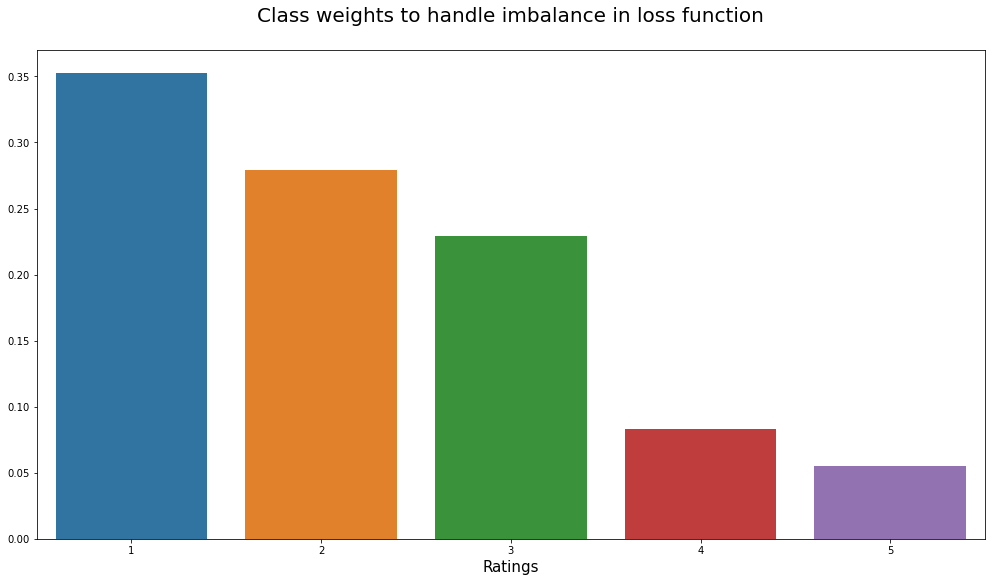

In [7]:
# Class weights - to tackle class imbalance in loss function
class_weights = data["Rating"].value_counts(normalize=True, ascending=True)
class_weights = 1/class_weights
class_weights = np.array(list(map(lambda x: x/sum(class_weights), class_weights)))
plt.figure(figsize=(17, 9))
sns.barplot(x=np.arange(1, 6), y=class_weights)
plt.title('Class weights to handle class imbalance in loss function\n', fontsize=20)
plt.xlabel('Ratings', fontsize=15)
plt.show()

In [10]:
# Apostrophe dictionaries to handle misspelled words
apposV2 = {
    "n't": "not",
    "are not" : "are not",
    "ca" : "can",
    "could n't" : "could not",
    "did n't" : "did not",
    "does n't" : "does not",
    "do n't" : "do not",
    "had n't" : "had not",
    "has n't" : "has not",
    "have n't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "I would",
    "i'd" : "I had",
    "i'll" : "I will",
    "i'm" : "I am",
    "is n't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "might n't" : "might not",
    "must n't" : "must not",
    "sha" : "shall",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "should n't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "were n't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "wo" : "will",
    "would n't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "was n't": "was not",
    "we'll":"we will",
    "did n't": "did not"
}

appos = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "I would",
    "i'd" : "I had",
    "i'll" : "I will",
    "i'm" : "I am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not"
}

In [11]:
# Processing the corpus (reviews text)
def cleanse_text(txt):
    stop_words = set(stopwords.words('english'))
    lower_case = txt.lower() # Text in lower case
    lower_case = lower_case.replace(".", " . ") # To remove full stops afterwards while removing punctuation
    lower_case = ' '.join(word.strip(string.punctuation) for word in lower_case.split()) # Remove punctuation
    words = word_tokenize(lower_case) # Tokenize text
    words = [word for word in words if word.isalpha()] # Remove numbers
    words = [apposV2[word] if word in apposV2 else word for word in words] # Correct using apposV2 as mentioned above
    words = [appos[word] if word in appos else word for word in words] # Correct using appos as mentioned above
    clean_words = [w for w in words if not w in stop_words] 
    
    return clean_words

lemmatizer = WordNetLemmatizer() 
def lemmatize(data):
    lemadata=[]
    for j in data:
        x = j.lower()
        x = lemmatizer.lemmatize(j, pos='n')
        x = lemmatizer.lemmatize(j, pos='v')
        x = lemmatizer.lemmatize(j, pos='a')
        x = lemmatizer.lemmatize(j, pos='r')
        x = lemmatizer.lemmatize(x)
        lemadata.append(x)
    return lemadata


clean_corpus = list(map(cleanse_text, corpus))
clean_corpus = list(map(lemmatize, clean_corpus))
clean_corpus = list(map(lambda el: ' '.join(el), clean_corpus)) # Joining back texts
vocab, word_counts = vocabulary(list(map(lambda review: review.split(), clean_corpus)))

In [12]:
word_df = pd.DataFrame(list(word_counts.items()), columns=['Keyword', 'Count'])

In [13]:
# Top 20 words
word_df[:20]

,Keyword,Count
0,hotel,53807
1,room,47334
2,great,21421
3,good,17395
4,staff,16657
5,stay,15578
6,night,14048
7,day,13092
8,time,12885
9,nice,12604


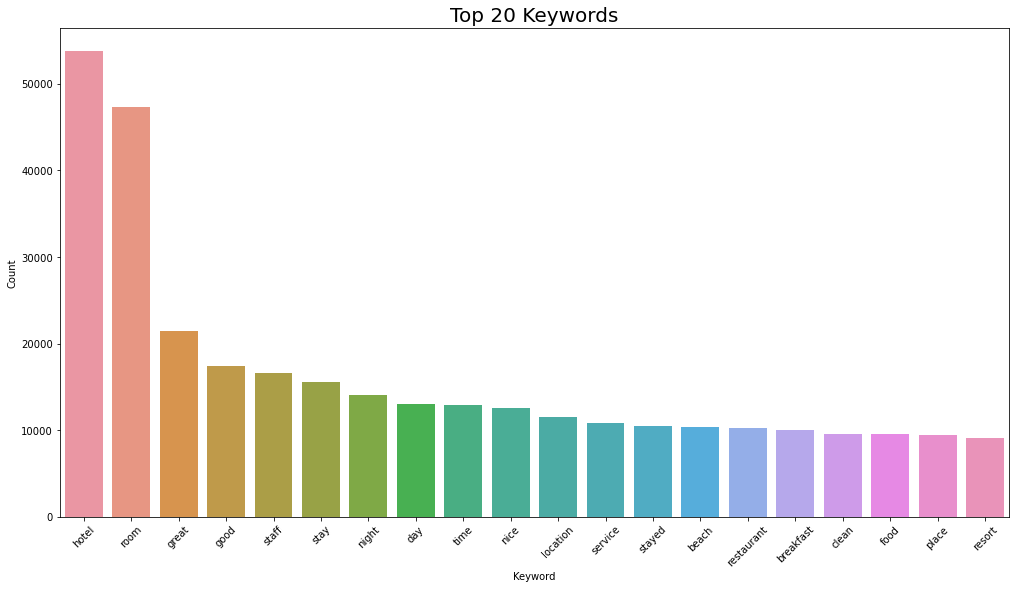

In [14]:
plt.figure(figsize=(17, 9))
sns.barplot(data=word_df[:20], x="Keyword", y="Count")
plt.tick_params(axis='x', labelrotation=45)
plt.title("Top 20 Keywords", fontsize=20)
plt.show()

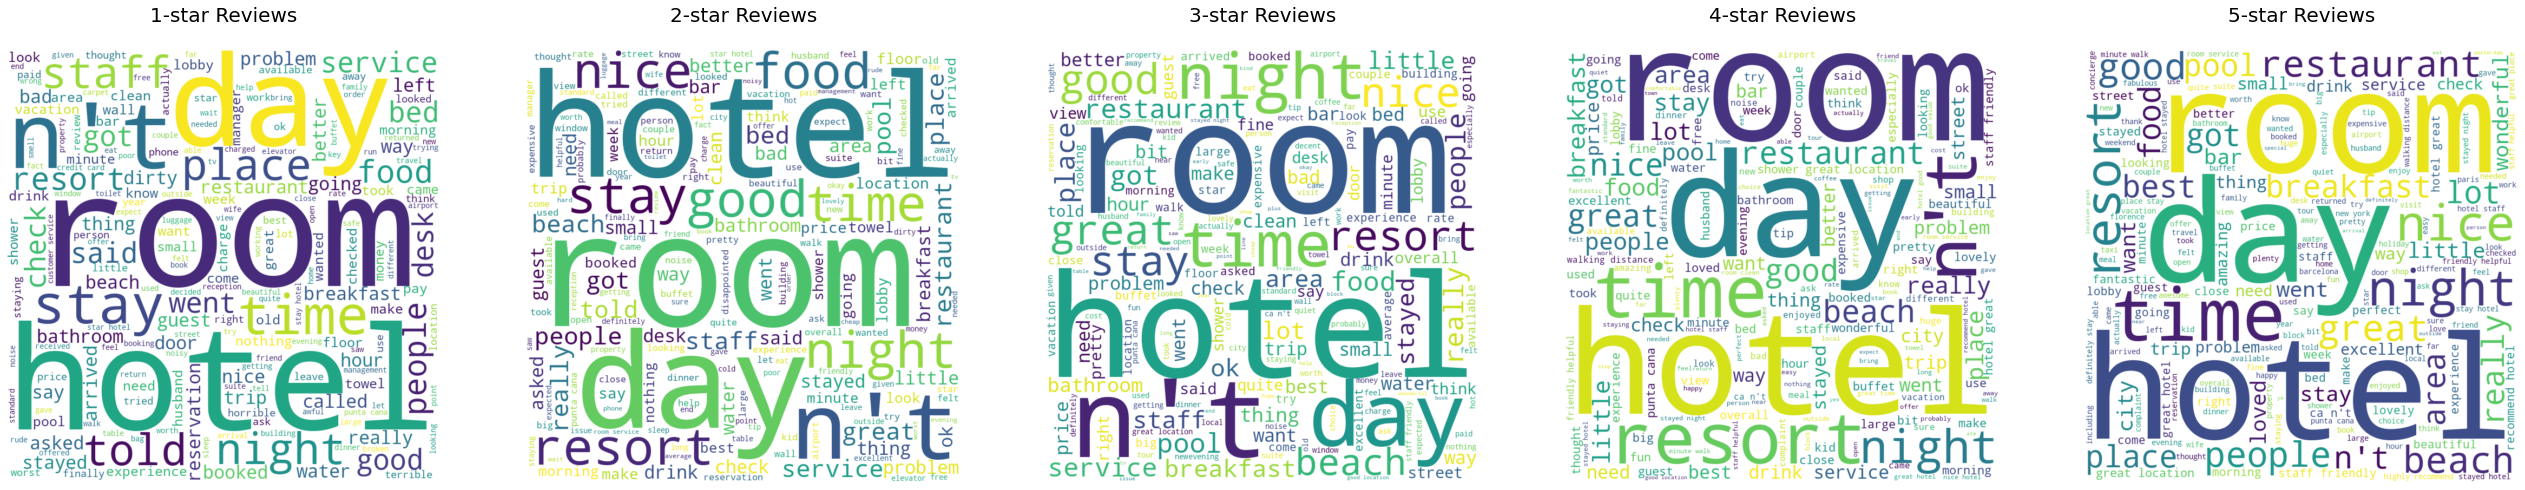

In [15]:
fig, axs = plt.subplots(1, n_classes, figsize=(45, 8), facecolor=None)

for i, el in enumerate(class_names):
    text =''
    for k in data[data['Rating']==el]['Review'].values:
        text+=k + ' '

    wc = WordCloud(width=800, height=800, background_color="white", min_font_size=10, repeat=True)
    wc.generate(text)
    axs[i].axis("off")
    axs[i].set_title(f'{el}-star Reviews\n', fontsize=20)
    axs[i].imshow(wc, interpolation="bilinear")

## Count-based models (``CountVectorizer``/ ``TfIdfVectorizer``)

We start by testing some basic models on our data to fulfill the task of predicting hotel ratings from reviews.

In [27]:
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

C:\Users\davys\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [31]:
# Splitting data into test and training sets (Multi-class classification task)
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(clean_corpus, y_true-1, test_size=.2, stratify=y_true-1)

### ``MultinomialNB`` model

In [32]:
pipeline10 = Pipeline([
    ('vect', CountVectorizer(max_features=40000, ngram_range=(1,2))),
    ('clf_nb', MultinomialNB())
])

pipeline10.fit(train_texts_splt, train_labels_splt)

Pipeline(steps=[('vect',
                 CountVectorizer(max_features=40000, ngram_range=(1, 2))),
                ('clf_nb', MultinomialNB())])

In [33]:
val_preds = pipeline10.predict(val_texts)

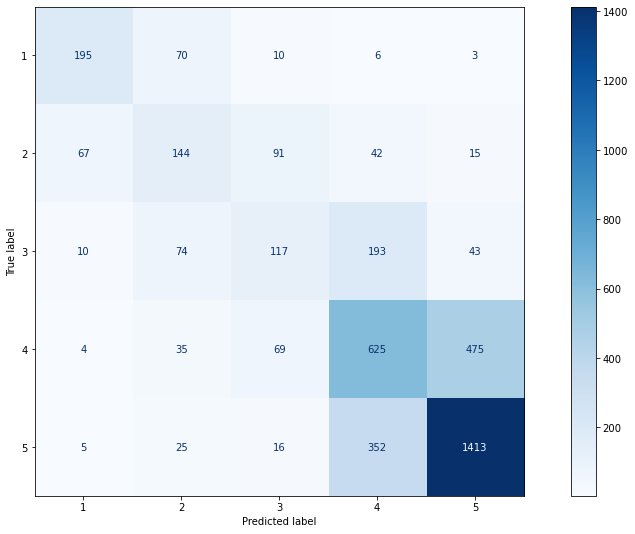

              precision    recall  f1-score   support

           1       0.69      0.69      0.69       284
           2       0.41      0.40      0.41       359
           3       0.39      0.27      0.32       437
           4       0.51      0.52      0.52      1208
           5       0.72      0.78      0.75      1811

    accuracy                           0.61      4099
   macro avg       0.55      0.53      0.54      4099
weighted avg       0.60      0.61      0.60      4099



In [34]:
_, ax1 = plt.subplots(figsize=(17, 9))
conf_mat = ConfusionMatrixDisplay(confusion_matrix(val_labels, val_preds), display_labels=list(map(str, class_names)))
conf_mat.plot(cmap='Blues', ax=ax1)
plt.show()

print(classification_report(val_labels, val_preds, target_names=list(map(str, class_names))))

In [39]:
pipeline11 = Pipeline([
    ('vect', CountVectorizer(max_features=40000, ngram_range=(1,2))),
    ('clf_xgb', xgb.XGBClassifier(objective='multi:softprob', seed=45, use_label_encoder=False))
])

pipeline11.fit(train_texts_splt, train_labels_splt)

#clf_xgb = xgb.XGBClassifier(objective='multi:softmax', seed=45)
#clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

[20:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('vect',
                 CountVectorizer(max_features=40000, ngram_range=(1, 2))),
                ('clf_xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=45, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, seed=45, subsample=1,
      

In [40]:
val_preds = pipeline11.predict(val_texts)

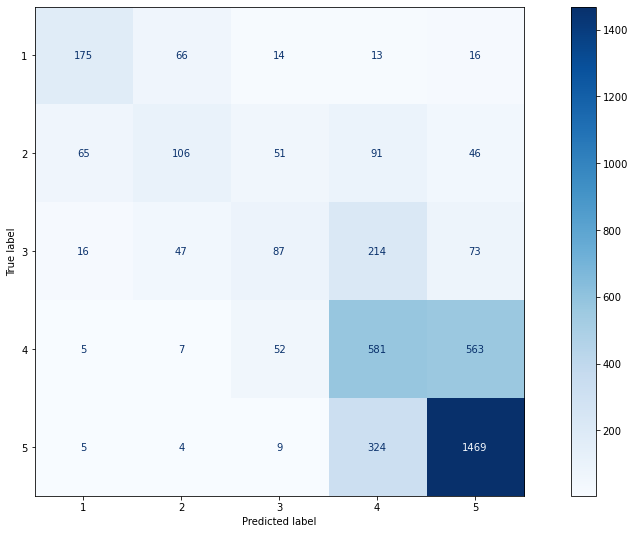

              precision    recall  f1-score   support

           1       0.66      0.62      0.64       284
           2       0.46      0.30      0.36       359
           3       0.41      0.20      0.27       437
           4       0.48      0.48      0.48      1208
           5       0.68      0.81      0.74      1811

    accuracy                           0.59      4099
   macro avg       0.54      0.48      0.50      4099
weighted avg       0.57      0.59      0.57      4099



In [41]:
_, ax1 = plt.subplots(figsize=(17, 9))
conf_mat = ConfusionMatrixDisplay(confusion_matrix(val_labels, val_preds), display_labels=list(map(str, class_names)))
conf_mat.plot(cmap='Blues', ax=ax1)
plt.show()

print(classification_report(val_labels, val_preds, target_names=list(map(str, class_names))))

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error

### ``LinearRegression`` model

In [45]:
# Splitting data into test and training sets (Regression task)
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(clean_corpus, y_true, test_size=.2)

In [46]:
pipeline20 = Pipeline([
    ('vect', TfidfVectorizer(max_features=40000, ngram_range=(1,2))),
    ('scaler', StandardScaler(with_mean=False)),
    ('reg', LinearRegression())
])

pipeline20.fit(train_texts_splt, train_labels_splt)
print("Test score (R²):", round(pipeline20.score(val_texts, val_labels), 4))

Test score (R²): 0.4931


In [47]:
y_pred = pipeline20.predict(val_texts)
print("RMSE on test set:", round(mean_squared_error(val_labels, y_pred, squared=False), 4))

RMSE on test set: 0.8789


**TO ADAPT !!!**

These results show that this model makes an error of roughly $0.86$ point (star) on average when predicting the rating of a hotel.

In [373]:
train_sizes, train_scores, test_scores = learning_curve(pipeline20, train_texts_splt, train_labels_splt, train_sizes=np.linspace(.3, 1.0, 5))

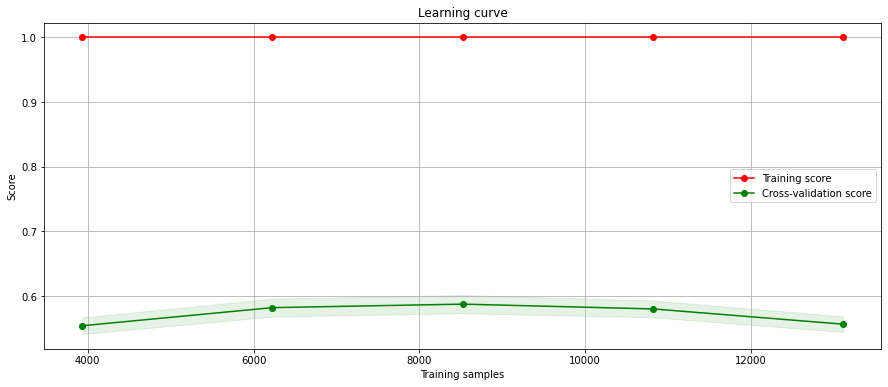

In [374]:
_, ax = plt.subplots(1, 1, figsize=(15, 6))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
ax.grid()
ax.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
ax.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
ax.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
ax.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
ax.legend(loc="best")
ax.set_xlabel("Training samples")
ax.set_ylabel("Score")
ax.set_title("Learning curve")
plt.show()

The model is overfitting...

### ``RidgeCV`` model

In [48]:
pipeline21 = Pipeline([
    ('vect', TfidfVectorizer(max_features=40000, ngram_range=(1,2))),
    ('reg', RidgeCV(alphas=np.linspace(0.1, 10, 10), cv=5))
])

pipeline21.fit(train_texts_splt, train_labels_splt)
print("Test score (R²):", round(pipeline21.score(val_texts, val_labels), 4))

Test score (R²): 0.6658


In [49]:
y_pred = pipeline21.predict(val_texts)
print("RMSE on test set:", round(mean_squared_error(val_labels, y_pred, squared=False), 4))

RMSE on test set: 0.7137


**TO ADAPT !!!**

These results show that this model makes an error of roughly $0.86$ point (star) on average when predicting the rating of a hotel.

In [375]:
train_sizes, train_scores, test_scores = learning_curve(pipeline21, train_texts_splt, train_labels_splt, train_sizes=np.linspace(.3, 1.0, 5))

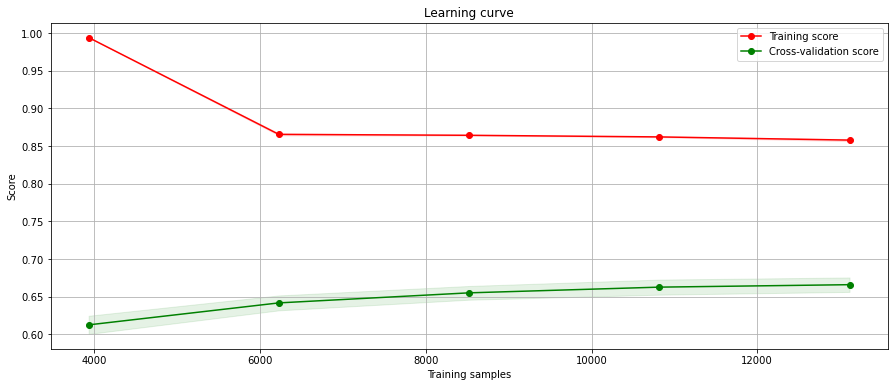

In [376]:
_, ax = plt.subplots(1, 1, figsize=(15, 6))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
ax.grid()
ax.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
ax.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
ax.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
ax.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
ax.legend(loc="best")
ax.set_xlabel("Training samples")
ax.set_ylabel("Score")
ax.set_title("Learning curve")
plt.show()

### ``RandomForest`` model

In [78]:
pipeline22 = Pipeline([
    ('vect', TfidfVectorizer(max_features=1000, ngram_range=(1,2))),
    ('scaler', StandardScaler(with_mean=False)),
    ('reg', RandomForestRegressor(n_estimators=50))
])

pipeline22.fit(train_texts_splt, train_labels_splt)
print("Test score (R²):", round(pipeline22.score(val_texts, val_labels), 4))

Test score (R²): 0.5261


In [79]:
y_pred = pipeline22.predict(val_texts)
print("RMSE on test set:", round(mean_squared_error(val_labels, y_pred, squared=False), 4))

RMSE on test set: 0.8498


**TO ADAPT !!!**

These results show that this model makes an error of roughly $0.86$ point (star) on average when predicting the rating of a hotel.

In [53]:
pipeline23 = Pipeline([
    ('vect', TfidfVectorizer(max_features=40000, ngram_range=(1,2))),
    ('scaler', StandardScaler(with_mean=False)),
    ('reg', xgb.XGBRegressor())
])

pipeline23.fit(train_texts_splt, train_labels_splt)
print("Test score (R²):", round(pipeline23.score(val_texts, val_labels), 4))

Test score (R²): 0.5708


In [ ]:
y_pred = pipeline23.predict(val_texts)
print("RMSE on test set:", round(mean_squared_error(val_labels, y_pred, squared=False), 4))

RMSE on test set: 0.8324


**TO ADAPT !!!**

These results show that this model makes an error of roughly $0.86$ point (star) on average when predicting the rating of a hotel.

## Embeddings-based models

### Quick study of the data

We would like to get an idea of what's in these hotel reviews before we proceed. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order: we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).  

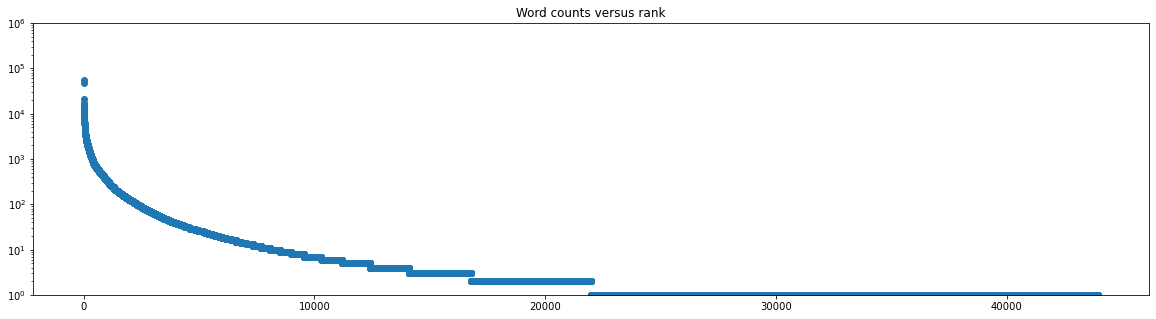

Vocabulary size: 43975
Part of the corpus by taking the "x" most frequent words:
5000 : 0.93
10000 : 0.97
15000 : 0.98
20000 : 0.99
25000 : 0.99
30000 : 0.99
35000 : 1.00
40000 : 1.00


In [56]:
rank_counts = {w:[vocab[w], word_counts[w]] for w in vocab}
rank_counts_array = np.array(list(rank_counts.values()))

plt.figure(figsize=(20, 5))
plt.title('Word counts versus rank')
plt.yscale('log')
plt.ylim(1, 1e6)
plt.scatter(rank_counts_array[:,0], rank_counts_array[:,1])
plt.show()

print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words:')
for i in range(5000, len(vocab), 5000):
    print('%i : %.2f' % (i, np.sum(rank_counts_array[:i, 1]) / np.sum(rank_counts_array[:,1]) ))

We can be satisfied with a vocabulary of 15,000 (we choose this value because it corresponds to 96% of the most frequent words) - this is important, because it will determine the size of the objects we will manipulate. 

In [66]:
vocab_15k, word_counts_15k = vocabulary(list(map(lambda review: review.split(), clean_corpus)), 15000)

This cell is of help in case you don't have that specific version of the module gensim (in order to be able to run Glove-Embedding-related cells properly).

In [15]:
# !pip install gensim==4.0.0

In [67]:
# Loading 300-sized Glove embeddings (meaning there are 300 features)
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

We can extract the embedding matrix this way, and check its size:

In [68]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

(400000, 300)


We can see that there are $400,000$ words represented, and that the embeddings are of size $300$. We define a function that returns, from the loaded model, the vocabulary and the embedding matrix according to the structures we used before. We add, here again, an unknown word "UNK" in case there are words in our data that are not part of the $400,000$ words represented here. 

In [81]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

In [82]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab_15k)
print(GloveEmbeddings.shape)

(15001, 300)


In [83]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.sum):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = np_func([embeddings[vocabulary.get(w, -1)] for w in texts[0]], axis=0).reshape(1,-1)

    for text in texts[1:]:
        representations = np.concatenate([representations, np_func([embeddings[vocabulary.get(w, -1)] for w in text], axis=0).reshape(1,-1)])

    return representations

### ``LinearRegression`` model

In [ ]:
# Splitting data into test and training sets (Regression task)
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(clean_corpus, y_true, test_size=.2)

In [84]:
# With Glove Embeddings...
train_rep = sentence_representations(train_texts_splt, vocab_15k, GloveEmbeddings)
val_rep = sentence_representations(val_texts, vocab_15k, GloveEmbeddings)

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
train_repn = scaler.fit_transform(train_rep)
val_repn = scaler.transform(val_rep)
regressor = LinearRegression().fit(train_repn, train_labels_splt)
print("Test score (R²):", round(regressor.score(val_repn, val_labels), 4))

Test score (R²): 0.0999


In [86]:
y_pred = regressor.predict(val_repn)
print("RMSE on test set:", round(mean_squared_error(val_labels, y_pred, squared=False), 4))

RMSE on test set: 1.1712


### ``RidgeCV`` model

In [97]:
ridge_reg = RidgeCV(alphas=np.linspace(0.1, 10, 10), cv=5).fit(train_repn, train_labels_splt)
print("Test score (R²):", round(ridge_reg.score(val_repn, val_labels), 4))

Test score (R²): 0.0998


In [98]:
y_pred = ridge_reg.predict(val_repn)
print("RMSE on test set:", round(mean_squared_error(val_labels, y_pred, squared=False), 4))

RMSE on test set: 1.1713


# Reviews classification (rating) with Pytorch

In [94]:
import torch
import torch.nn as nn

In [95]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [130]:
train_f, test_f, train_c, test_c = train_test_split(list(map(lambda el: el.split(), clean_corpus)), categories, test_size=.2, stratify=y_true-1)

In [158]:
MAX_LENGTH = 400
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = MAX_LENGTH, min_freq = 5):
        # Read all files and put the data in a list of strings
        self.data = data
        
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, min_freq)
            
        # Transform words into lists of indexes ...
        indexed_data = [[self.word2idx.get(w, self.word2idx['UNK']) for w in text] for text in self.data]
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = list(map(torch.LongTensor, indexed_data))
        # And the categories into a FloatTensor
        tensor_y = torch.FloatTensor(np.array(categories))
        # To finally cut it when it's above the maximum length
        cut_tensor_data = [el[:max_length] for el in tensor_data]
        
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=0)
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, count_threshold):
        word_count = {}
        for i, text in enumerate(corpus):
            for token in text:
                if token in word_count.keys():
                    word_count[token] += 1
                else:
                    word_count[token] = 1
            
        word_count = dict(sorted(word_count.items(), key=lambda el: -el[1]))
        
        word_index = {}
        i = 1
        keys = list(word_count.keys())
        while word_count[keys[i]] > count_threshold and i < len(word_count):
            word_index[keys[i]] = i
            i += 1  
        
        word_index['UNK'] = len(word_index) + 1
        idx_word = {v: k for k, v in word_index.items()}
        
        return word_index, idx_word
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.word2idx, self.idx2word

In [159]:
training_dataset = TextClassificationDataset(train_f, train_c)
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [160]:
# valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))

In [161]:
training_dataloader = DataLoader(training_dataset, batch_size = 1000, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size = 100)
test_dataloader = DataLoader(test_dataset, batch_size = 100)

In [162]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([1000, 400])
torch.Size([1000, 5])


### A simple averaging model

In [168]:
class AveragingModel(nn.Module):    
    def __init__(self, embedding_dim, vocabulary_size):
        super().__init__()
        # Create an embedding object.
        self.embeddings = nn.Embedding(vocabulary_size+1, embedding_dim, padding_idx=0)
        self.linear = nn.Linear(embedding_dim, n_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, inputs):
        # Remember: the inputs are written as Batch_size * seq_length * embedding_dim
        x = self.embeddings(inputs).mean(axis=1)
        o = self.linear(x)
        s = self.softmax(o)
        return s

In [169]:
# Implementing a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader, verbose = True):
    model.train()
    losses = []
    accs = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model(x)
        # (2) Compute the loss 
        loss = criterion(pred, y)
        # (3) Compute gradients with the criterion
        loss.backward()
        # (4) Update weights with the optimizer
        opt.step() 
        losses.append(loss.item())
        # (5) Count the number of correct predictions in the batch
        num_corrects = sum(torch.argmax(pred, dim=1)==torch.argmax(y, dim=1))
        acc = 100.0 * num_corrects/len(y)
        accs.append(acc.item())
        
        if verbose and i%4 == 0:
            print("Batch " + str(i) + " : Training loss = " + str(round(loss.item(), 4)) + " - Training acc = " + str(round(acc.item(), 2)) + " %")
    
    return np.array([[np.mean(losses)], [np.mean(accs)]])

In [170]:
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            pred = model(x)
            loss = criterion(pred, y)
            num_corrects = sum(torch.argmax(pred, dim=1)==torch.argmax(y, dim=1))
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [171]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary. 
def experiment(model, opt, criterion, num_epochs = 5, early_stopping = True, train_data = training_dataloader, val_data = test_dataloader, test_data = test_dataloader, verbose = True):
    train_history = None
    val_history = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("\nBeginning training...")
    for e in range(num_epochs):
        if verbose:
            print("\nEpoch " + str(e+1) + "/" + str(num_epochs))
        if e == 0:
            train_history = train_epoch(model, opt, criterion, train_data, verbose)
        else:
            train_history = np.concatenate([train_history, train_epoch(model, opt, criterion, train_data, verbose)], axis=1)
        valid_loss, valid_acc = eval_model(model, criterion, val_data)
        val_history.append([[valid_loss], [valid_acc]])

        if verbose:
            print("Training loss = " + str(round(train_history[0, -1], 4)) + " - Training acc = " + str(round(train_history[1, -1], 2)) + 
              " % - Validation loss = " + str(round(valid_loss, 4)) + " - Validation acc = " + str(round(valid_acc, 2)) + " %")
        
        if e+1 < num_epochs and early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                if verbose:
                    print("Early stopping!")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_data)
    
    print("==> Epoch " + str(e+1) + "/" + str(num_epochs) + " : Test loss = " + str(round(test_loss, 4)) + " - Test acc = " + str(round(test_acc, 2)) + " %")
    val_history = np.array(val_history).reshape(e+1, 2).T
    
    return train_history, val_history

In [187]:
import torch.optim as optim

EMBEDDING_DIM = 500 # User-defined value

model1 = AveragingModel(EMBEDDING_DIM, len(training_word2idx))
opt = optim.Adam(model1.parameters(), lr=0.05, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(np.array(class_weights)))
train_hist1, val_hist1 = experiment(model1, opt, criterion, num_epochs=10, early_stopping=False)


Beginning training...

Epoch 1/10
Batch 0 : Training loss = 0.1977 - Training acc = 10.7 %
Batch 4 : Training loss = 0.1901 - Training acc = 50.9 %
Batch 8 : Training loss = 0.1656 - Training acc = 59.1 %
Batch 12 : Training loss = 0.1658 - Training acc = 58.8 %
Batch 16 : Training loss = 0.1516 - Training acc = 62.5 %
Training loss = 0.1745 - Training acc = 50.97 % - Validation loss = 0.1645 - Validation acc = 58.5 %

Epoch 2/10
Batch 0 : Training loss = 0.1486 - Training acc = 64.4 %
Batch 4 : Training loss = 0.1504 - Training acc = 67.1 %
Batch 8 : Training loss = 0.1561 - Training acc = 67.2 %
Batch 12 : Training loss = 0.1486 - Training acc = 66.1 %
Batch 16 : Training loss = 0.1478 - Training acc = 70.15 %
Training loss = 0.1499 - Training acc = 67.37 % - Validation loss = 0.1639 - Validation acc = 60.99 %

Epoch 3/10
Batch 0 : Training loss = 0.1423 - Training acc = 76.4 %
Batch 4 : Training loss = 0.1457 - Training acc = 73.8 %
Batch 8 : Training loss = 0.1379 - Training acc =

### With Glove embeddings

In [188]:
# This utility function differs from the latter as we now consider the padding token (note the +1 at the initialization of the embeddings matrix)
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1, glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [189]:
class PretrainedAveragingModel(nn.Module):
    
    def __init__(self, embeddings, retrain=False):
        super().__init__()
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings), freeze=not retrain, padding_idx=0)
        self.linear = nn.Linear(embeddings.shape[1], n_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, inputs):
        # The inputs are written as Batch_size * seq_length * embedding_dim
        x = self.embeddings(inputs).mean(axis=1)
        o = self.linear(x)
        s = self.softmax(o) 
        return s

In [190]:
model2 = PretrainedAveragingModel(GloveEmbeddings)
opt = optim.Adam(model2.parameters(), lr=0.1, betas=(0.9, 0.999))
train_hist2, val_hist2 = experiment(model2, opt, criterion, num_epochs=10, early_stopping=False)


Beginning training...

Epoch 1/10
Batch 0 : Training loss = 0.1966 - Training acc = 21.8 %
Batch 4 : Training loss = 0.1957 - Training acc = 33.4 %
Batch 8 : Training loss = 0.1827 - Training acc = 49.7 %
Batch 12 : Training loss = 0.1879 - Training acc = 47.4 %
Batch 16 : Training loss = 0.1855 - Training acc = 35.71 %
Training loss = 0.1916 - Training acc = 35.31 % - Validation loss = 0.1868 - Validation acc = 42.69 %

Epoch 2/10
Batch 0 : Training loss = 0.1929 - Training acc = 44.2 %
Batch 4 : Training loss = 0.1792 - Training acc = 49.6 %
Batch 8 : Training loss = 0.1779 - Training acc = 48.3 %
Batch 12 : Training loss = 0.1831 - Training acc = 53.0 %
Batch 16 : Training loss = 0.177 - Training acc = 46.68 %
Training loss = 0.1839 - Training acc = 48.39 % - Validation loss = 0.1823 - Validation acc = 48.52 %

Epoch 3/10
Batch 0 : Training loss = 0.1796 - Training acc = 50.9 %
Batch 4 : Training loss = 0.1784 - Training acc = 49.6 %
Batch 8 : Training loss = 0.1843 - Training acc 

In [191]:
model3 = PretrainedAveragingModel(GloveEmbeddings, retrain=True)
opt = optim.Adam(model3.parameters(), lr=0.005, betas=(0.9, 0.999))
train_hist3, val_hist3 = experiment(model3, opt, criterion, num_epochs=10, early_stopping=False)


Beginning training...

Epoch 1/10
Batch 0 : Training loss = 0.1955 - Training acc = 11.1 %
Batch 4 : Training loss = 0.1831 - Training acc = 35.0 %
Batch 8 : Training loss = 0.1861 - Training acc = 36.0 %
Batch 12 : Training loss = 0.1791 - Training acc = 57.2 %
Batch 16 : Training loss = 0.1704 - Training acc = 52.04 %
Training loss = 0.1774 - Training acc = 42.94 % - Validation loss = 0.1668 - Validation acc = 50.92 %

Epoch 2/10
Batch 0 : Training loss = 0.15 - Training acc = 56.1 %
Batch 4 : Training loss = 0.162 - Training acc = 59.9 %
Batch 8 : Training loss = 0.1571 - Training acc = 63.7 %
Batch 12 : Training loss = 0.1632 - Training acc = 63.8 %
Batch 16 : Training loss = 0.1449 - Training acc = 64.29 %
Training loss = 0.1555 - Training acc = 62.81 % - Validation loss = 0.1658 - Validation acc = 58.43 %

Epoch 3/10
Batch 0 : Training loss = 0.1491 - Training acc = 68.2 %
Batch 4 : Training loss = 0.156 - Training acc = 66.5 %
Batch 8 : Training loss = 0.1502 - Training acc = 6

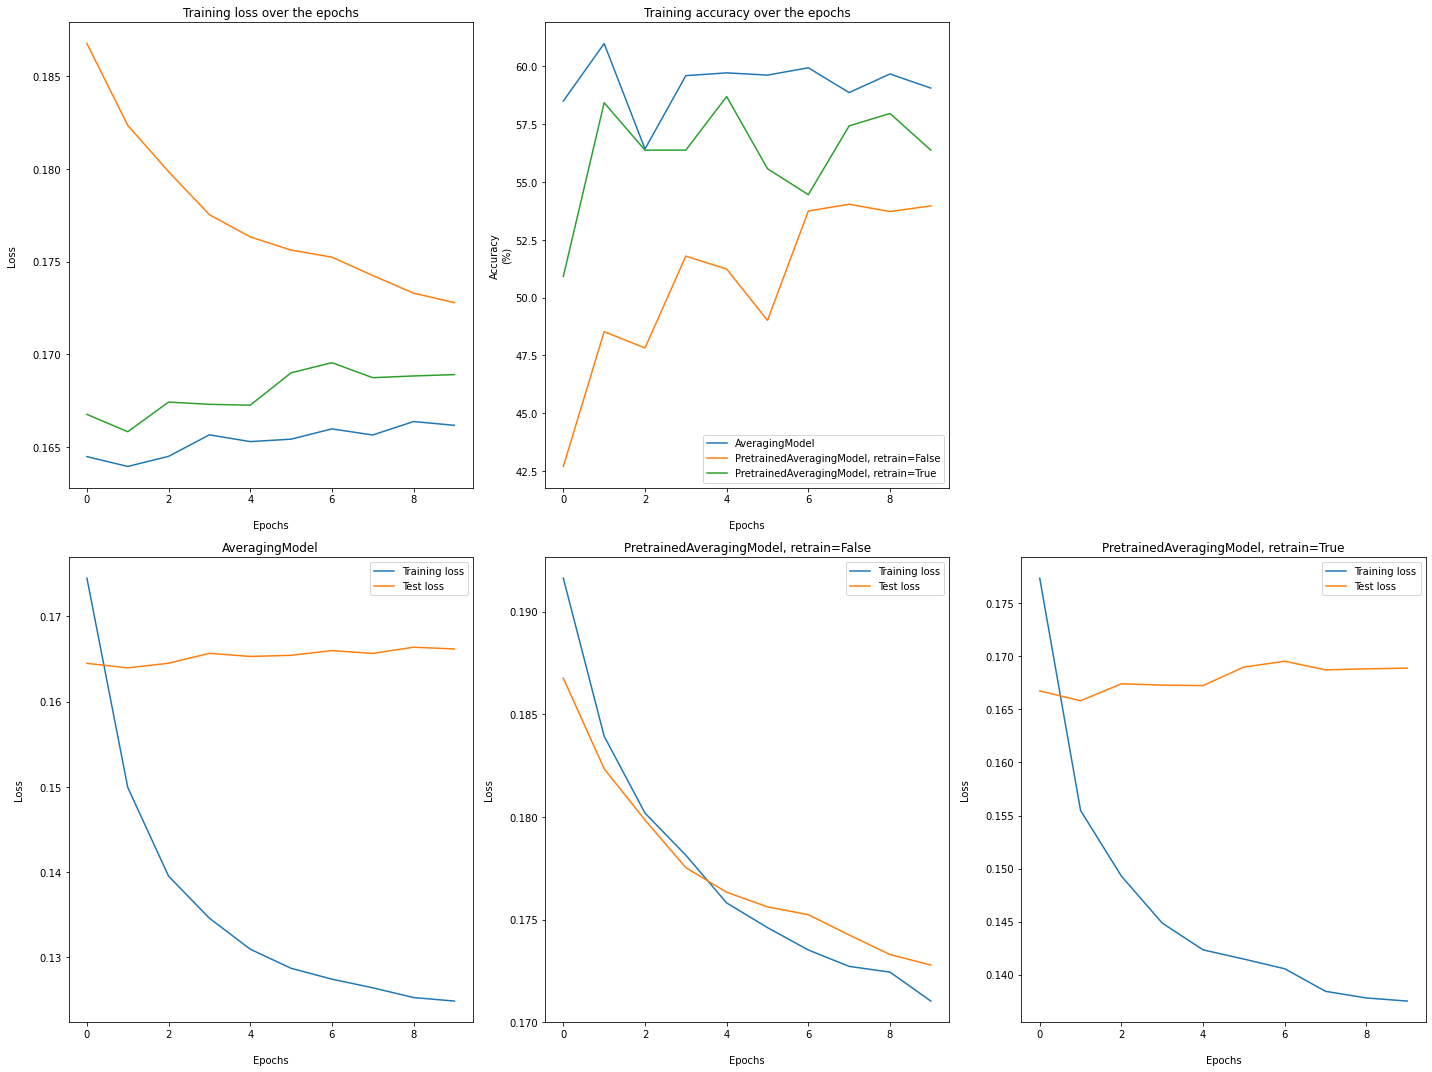

In [192]:
plt.figure(figsize=(20, 15))
plt.subplot(231)
plt.plot(val_hist1[0])
plt.plot(val_hist2[0])
plt.plot(val_hist3[0])
plt.title("Training loss over the epochs")
plt.xlabel('\nEpochs')
plt.ylabel('Loss\n')

plt.subplot(232)
plt.plot(val_hist1[1])
plt.plot(val_hist2[1])
plt.plot(val_hist3[1])
plt.title("Training accuracy over the epochs")
plt.xlabel('\nEpochs')
plt.ylabel('Accuracy\n(%)')
plt.legend(['AveragingModel', 'PretrainedAveragingModel, retrain=False', 'PretrainedAveragingModel, retrain=True'])

plt.subplot(234)
plt.plot(train_hist1[0])
plt.plot(val_hist1[0])
plt.title("AveragingModel")
plt.xlabel('\nEpochs')
plt.ylabel('Loss\n')
plt.legend(['Training loss', 'Test loss'])

plt.subplot(235)
plt.plot(train_hist2[0])
plt.plot(val_hist2[0])
plt.title("PretrainedAveragingModel, retrain=False")
plt.xlabel('\nEpochs')
plt.ylabel('Loss\n')
plt.legend(['Training loss', 'Test loss'])

plt.subplot(236)
plt.plot(train_hist3[0])
plt.plot(val_hist3[0])
plt.title("PretrainedAveragingModel, retrain=True")
plt.xlabel('\nEpochs')
plt.ylabel('Loss\n')
plt.legend(['Training loss', 'Test loss'])
plt.tight_layout()
plt.show()

### Creating our own LSTM Model

In [382]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, r2_score

In [342]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_corpus)
X = tokenizer.texts_to_sequences(clean_corpus)
maxlength = max([len(x) for x in X])
VOC_SIZE = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(VOC_SIZE))
print("max length of sentence: {}".format(maxlength))

Vocabulary size: 43975
max length of sentence: 1794


In [343]:
X = pad_sequences(X, padding='post', maxlen=MAX_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X, categories, test_size=0.2, random_state=42, stratify=y_true-1)

In [350]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 50 # Arbitrary choices

model3 = tf.keras.Sequential([
    L.Embedding(VOC_SIZE, EMBEDDING_DIM, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(HIDDEN_DIM, return_sequences=True)),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.2),
    L.Dense(128, activation="relu"),
    L.Dropout(0.2),
    L.Dense(64, activation="relu"),
    L.Dropout(0.2),
    L.Dense(5, activation="softmax")
])

model3.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

In [351]:
hist3 = model3.fit(X_train, y_train, batch_size=256, validation_split=0.2, epochs=3)

Epoch 1/3
52/52 [==============================] - 8s 107ms/step - loss: 1.2371 - accuracy: 0.4635 - val_loss: 0.9787 - val_accuracy: 0.5599
Epoch 2/3
52/52 [==============================] - 5s 96ms/step - loss: 0.8538 - accuracy: 0.6234 - val_loss: 0.8595 - val_accuracy: 0.6252
Epoch 3/3
52/52 [==============================] - 5s 97ms/step - loss: 0.6217 - accuracy: 0.7435 - val_loss: 0.9274 - val_accuracy: 0.6142


In [360]:
y_hat = model3.predict(X_test)
pred_class = np.argmax(y_hat, axis=-1)
tt = np.zeros_like(y_hat, dtype=int)
for i in range(len(y_hat)):
    tt[i, pred_class[i]] = 1
acc = round(np.mean(np.sum(tt-y_test == np.zeros_like(y_hat, dtype=int), axis=1)//n_classes), 4)
print("Test accuracy:", acc)

Test accuracy: 0.6236


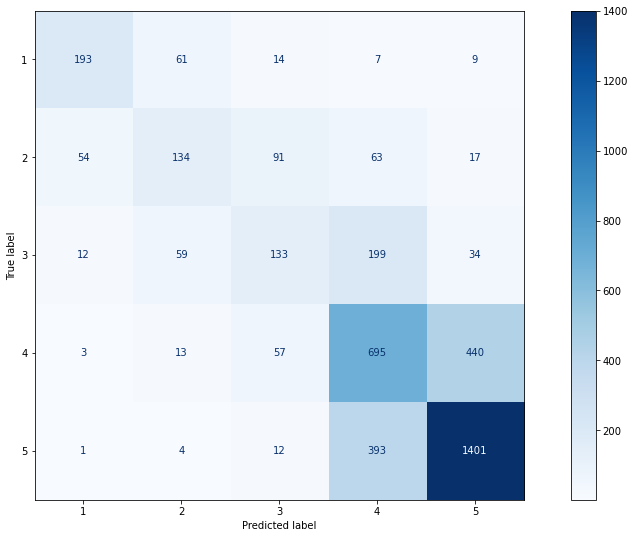

              precision    recall  f1-score   support

           1       0.73      0.68      0.71       284
           2       0.49      0.37      0.43       359
           3       0.43      0.30      0.36       437
           4       0.51      0.58      0.54      1208
           5       0.74      0.77      0.75      1811

    accuracy                           0.62      4099
   macro avg       0.58      0.54      0.56      4099
weighted avg       0.62      0.62      0.62      4099



In [361]:
_, ax1 = plt.subplots(figsize=(17, 9))
conf_mat = ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test, axis=-1), pred_class), display_labels=list(map(str, class_names)))
conf_mat.plot(cmap='Blues', ax=ax1)
plt.show()

print(classification_report(np.argmax(y_test, axis=-1), pred_class, target_names=list(map(str, class_names))))

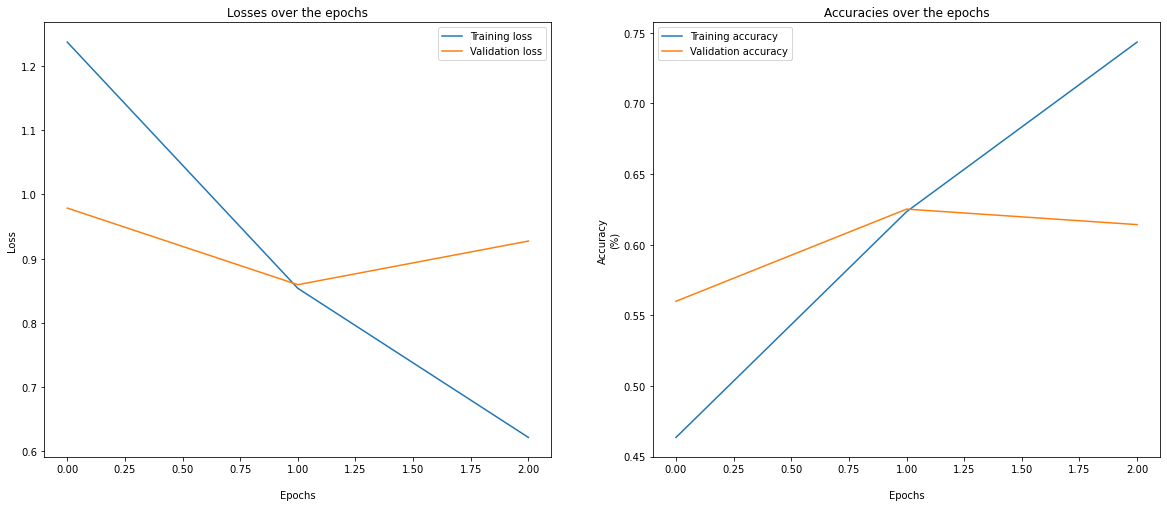

In [353]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title("Losses over the epochs")
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('\nEpochs')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title("Accuracies over the epochs")
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.xlabel('\nEpochs')
plt.ylabel('Accuracy\n(%)')

plt.show()

In [354]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, tokenizer.word_index)

In [355]:
EMBEDDING_DIM = GloveEmbeddings.shape[1]
HIDDEN_DIM = 50 # Arbitrary choices

model4 = tf.keras.Sequential([
    L.Embedding(VOC_SIZE, EMBEDDING_DIM, input_length=X.shape[1], weights=[GloveEmbeddings]),
    L.Bidirectional(L.LSTM(HIDDEN_DIM, return_sequences=True)),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.2),
    L.Dense(128, activation="relu"),
    L.Dropout(0.2),
    L.Dense(64, activation="relu"),
    L.Dropout(0.2),
    L.Dense(5, activation="softmax")
])

model4.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

In [356]:
hist4 = model4.fit(X_train, y_train, batch_size=256, validation_split=0.2, epochs=3)

Epoch 1/3
52/52 [==============================] - 8s 107ms/step - loss: 1.1159 - accuracy: 0.5084 - val_loss: 0.8875 - val_accuracy: 0.6029
Epoch 2/3
52/52 [==============================] - 5s 95ms/step - loss: 0.8213 - accuracy: 0.6404 - val_loss: 0.8473 - val_accuracy: 0.6264
Epoch 3/3
52/52 [==============================] - 5s 96ms/step - loss: 0.6758 - accuracy: 0.7074 - val_loss: 0.8530 - val_accuracy: 0.6343


In [363]:
y_hat = model4.predict(X_test)
pred_class = np.argmax(y_hat, axis=-1)
true_class = np.argmax(y_test, axis=-1)
print("Test accuracy:", round(accuracy_score(pred_class, true_class), 4))

Test accuracy: 0.6187


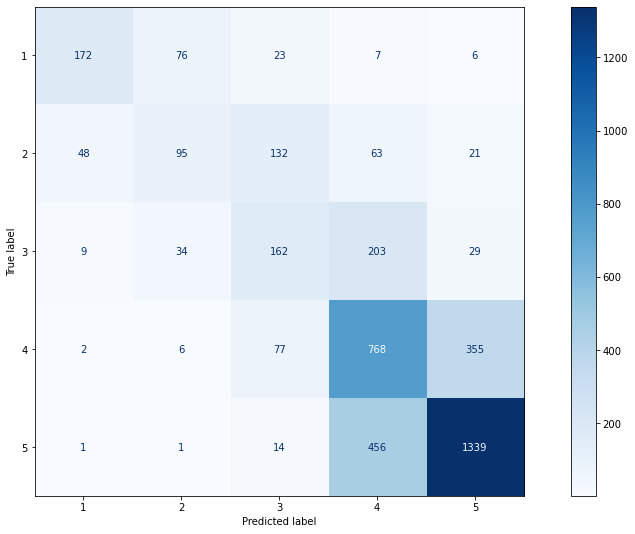

              precision    recall  f1-score   support

           1       0.74      0.61      0.67       284
           2       0.45      0.26      0.33       359
           3       0.40      0.37      0.38       437
           4       0.51      0.64      0.57      1208
           5       0.77      0.74      0.75      1811

    accuracy                           0.62      4099
   macro avg       0.57      0.52      0.54      4099
weighted avg       0.62      0.62      0.62      4099



In [364]:
_, ax1 = plt.subplots(figsize=(17, 9))
conf_mat = ConfusionMatrixDisplay(confusion_matrix(true_class, pred_class), display_labels=list(map(str, class_names)))
conf_mat.plot(cmap='Blues', ax=ax1)
plt.show()

print(classification_report(true_class, pred_class, target_names=list(map(str, class_names))))

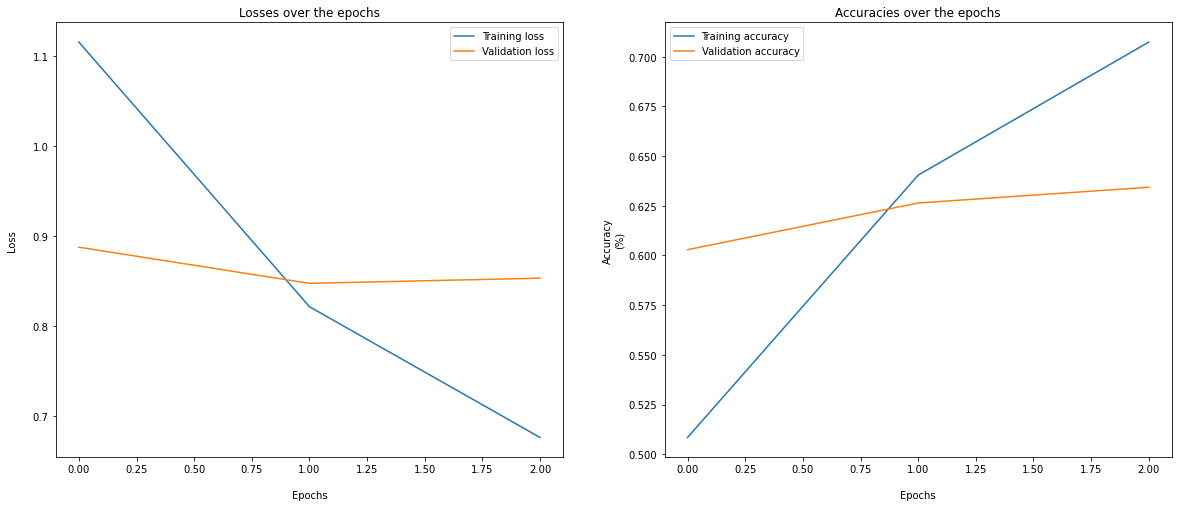

In [358]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title("Losses over the epochs")
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('\nEpochs')
plt.ylabel('Loss\n')

plt.subplot(122)
plt.plot(hist4.history['accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.title("Accuracies over the epochs")
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.xlabel('\nEpochs')
plt.ylabel('Accuracy\n(%)')

plt.show()

In [393]:
EMBEDDING_DIM = GloveEmbeddings.shape[1]
HIDDEN_DIM = 50 # Arbitrary choices

model5 = tf.keras.Sequential([
    L.Embedding(VOC_SIZE, EMBEDDING_DIM, input_length=X.shape[1], weights=[GloveEmbeddings]),
    L.Bidirectional(L.LSTM(HIDDEN_DIM, return_sequences=True)),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.2),
    L.Dense(128, activation="relu"),
    L.Dropout(0.2),
    # L.Dense(64, activation="relu"),
    # L.Dropout(0.2),
    L.Dense(1)
])

model5.compile(loss='mae', optimizer=Adam(), metrics=['mse'])

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=42)
hist5 = model5.fit(X_train, y_train, batch_size=256, validation_split=0.2, epochs=5)

Epoch 1/5
52/52 [==============================] - 8s 110ms/step - loss: 1.0024 - mse: 1.8158 - val_loss: 0.6279 - val_mse: 0.6393
Epoch 2/5
52/52 [==============================] - 5s 102ms/step - loss: 0.6645 - mse: 0.7015 - val_loss: 0.6133 - val_mse: 0.6169
Epoch 3/5
52/52 [==============================] - 5s 103ms/step - loss: 0.5706 - mse: 0.5284 - val_loss: 0.5979 - val_mse: 0.6037
Epoch 4/5
52/52 [==============================] - 5s 104ms/step - loss: 0.5166 - mse: 0.4401 - val_loss: 0.5773 - val_mse: 0.5440
Epoch 5/5
52/52 [==============================] - 5s 103ms/step - loss: 0.4671 - mse: 0.3610 - val_loss: 0.5886 - val_mse: 0.5537


In [395]:
y_hat = model5.predict(X_test)
print("Test score:", round(r2_score(y_hat, y_test), 4))

Test score: 0.4929


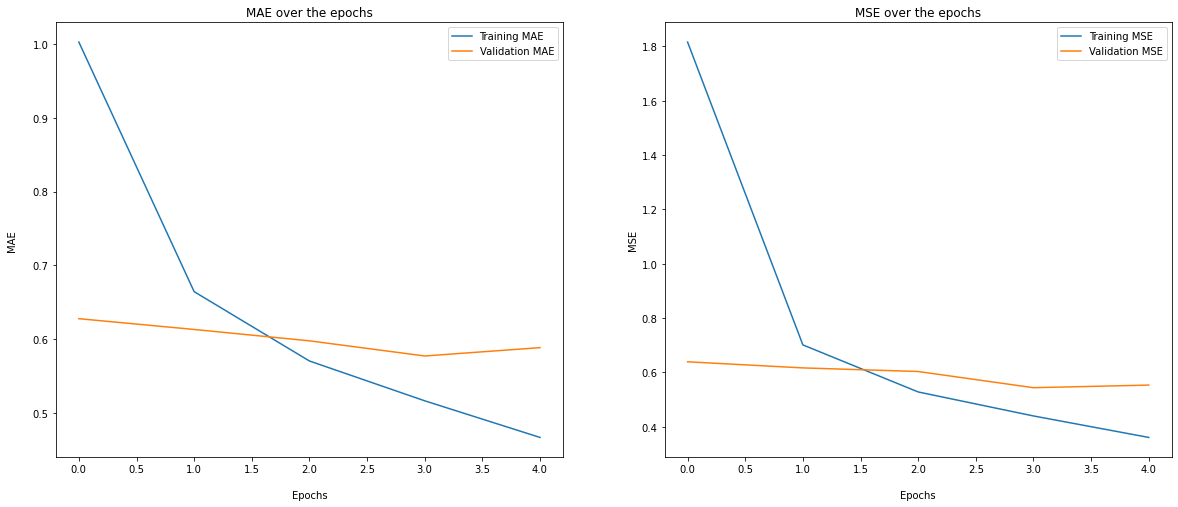

In [396]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(hist5.history['loss'])
plt.plot(hist5.history['val_loss'])
plt.title("MAE over the epochs")
plt.legend(['Training MAE', 'Validation MAE'])
plt.xlabel('\nEpochs')
plt.ylabel('MAE\n')

plt.subplot(122)
plt.plot(hist5.history['mse'])
plt.plot(hist5.history['val_mse'])
plt.title("MSE over the epochs")
plt.legend(['Training MSE', 'Validation MSE'])
plt.xlabel('\nEpochs')
plt.ylabel('MSE')

plt.show()